<a href="https://colab.research.google.com/github/gombergere/arthomas/blob/master/NewRubik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Le Tranfer Learning est la technique de DL qui fait le buzz en ce moment
# c'est bien explique dans les deux articles suivants
# https://rubikscode.net/2019/11/18/transfer-learning-with-tensorflow-2-model-fine-tuning/
# https://rubikscode.net/2019/11/11/transfer-learning-with-tensorflow-2/
# En gros on part d'un modele de DL déja entrainé sur une trés grande quantité d'exemples
# ...et on le modifie légèrement pour identifier un exemple qui n'appartient pas au modéle-de référence.
#...Attention Colab n'est pas passé à Tensorflow 2 que demande le modéle. D'ou la modif, bien pratique dans "try:"
#...j'ai passé beaucoup de temps à corriger ce modèle
#

In [0]:
import numpy as np
import matplotlib.pyplot as plt

#import tensorflow as tf
#import tensorflow_datasets as tfds

IMG_SIZE = 160
BATCH_SIZE = 32
SHUFFLE_SIZE = 1000
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

keras = tf.keras

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [0]:
class DataLoader(object):
    def __init__(self, image_size, batch_size):
        
        self.image_size = image_size
        self.batch_size = batch_size
        
        # 80% train data, 10% validation data, 10% test data
        split_weights = (8, 1, 1)
        splits = tfds.Split.TRAIN.subsplit(weighted=split_weights)
        
        (self.train_data_raw, self.validation_data_raw, self.test_data_raw), self.metadata = tfds.load(
            'cats_vs_dogs', split=list(splits),
            with_info=True, as_supervised=True)
        
        # Get the number of train examples
        self.num_train_examples = self.metadata.splits['train'].num_examples*80/100
        self.get_label_name = self.metadata.features['label'].int2str
        
        # Pre-process data
        self._prepare_data()
        self._prepare_batches()
        
    # Resize all images to image_size x image_size
    def _prepare_data(self):
        self.train_data = self.train_data_raw.map(self._resize_sample)
        self.validation_data = self.validation_data_raw.map(self._resize_sample)
        self.test_data = self.test_data_raw.map(self._resize_sample)
    
    # Resize one image to image_size x image_size
    def _resize_sample(self, image, label):
        image = tf.cast(image, tf.float32)
        image = (image/127.5) - 1
        image = tf.image.resize(image, (self.image_size, self.image_size))
        return image, label
    
    def _prepare_batches(self):
        self.train_batches = self.train_data.shuffle(1000).batch(self.batch_size)
        self.validation_batches = self.validation_data.batch(self.batch_size)
        self.test_batches = self.test_data.batch(self.batch_size)
   
    # Get defined number of  not processed images
    def get_random_raw_images(self, num_of_images):
        random_train_raw_data = self.train_data_raw.shuffle(1000)
        return random_train_raw_data.take(num_of_images)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


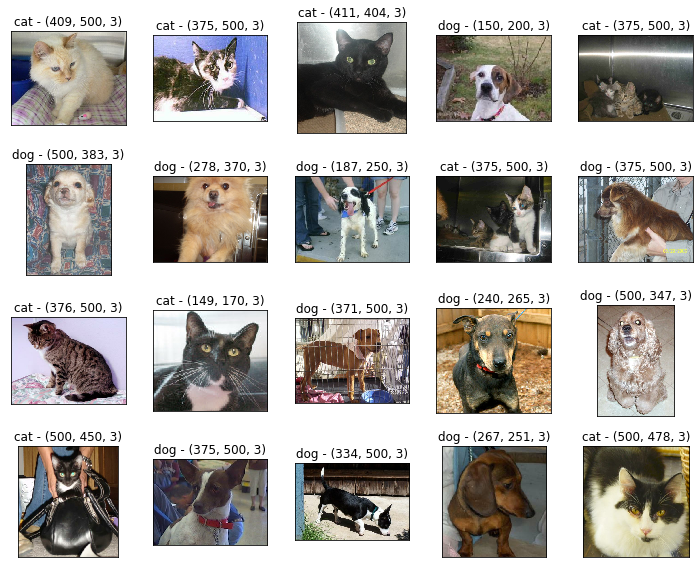

In [0]:
data_loader = DataLoader(IMG_SIZE, BATCH_SIZE)
plt.figure(figsize=(10, 8))
i = 0
for img, label in data_loader.get_random_raw_images(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title("{} - {}".format(data_loader.get_label_name(label), img.shape))
    plt.xticks([])
    plt.yticks([])
    i += 1
plt.tight_layout()
plt.show()

In [0]:
resnet_base = tf.keras.applications.ResNet101V2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

resnet_base.trainable = True

from_layer = 100

for layer in resnet_base.layers[:from_layer]:
    layer.trainable =  False

171319296/171317808 [==============================] - 12s 0us/step


In [0]:
class Wrapper(tf.keras.Model):
    def __init__(self, base_model):
        super(Wrapper, self).__init__()
        
        self.base_model = base_model
        self.average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        x = self.base_model(inputs)
        x = self.average_pooling_layer(x)
        output = self.output_layer(x)
        return output

In [0]:
base_learning_rate = 0.0001

resnet = Wrapper(resnet_base)
resnet.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
steps_per_epoch = round(data_loader.num_train_examples)//BATCH_SIZE
validation_steps = 20
loss, accuracy = resnet.evaluate(data_loader.test_batches, steps = validation_steps)

print("--------ResNet---------")
print("Loss: {:.2f}".format(loss))
print("Accuracy: {:.2f}".format(accuracy))

20/20 [==============================] - 11s 565ms/step - loss: 2.7295 - accuracy: 0.7672
--------ResNet---------
Loss: 2.73
Accuracy: 0.77


In [10]:
history = resnet.fit(data_loader.train_batches,
                    epochs=10,
                    validation_data=data_loader.validation_batches)

Epoch 1/10
582/582 [==============================] - 418s 718ms/step - loss: 0.8625 - accuracy: 0.9180 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
582/582 [==============================] - 390s 670ms/step - loss: 0.4480 - accuracy: 0.9489 - val_loss: 2.2970 - val_accuracy: 0.8453
Epoch 3/10
582/582 [==============================] - 390s 670ms/step - loss: 0.2811 - accuracy: 0.9563 - val_loss: 5.0535 - val_accuracy: 0.6578
Epoch 4/10
582/582 [==============================] - 390s 670ms/step - loss: 0.1677 - accuracy: 0.9714 - val_loss: 0.8398 - val_accuracy: 0.9246
Epoch 5/10
582/582 [==============================] - 389s 669ms/step - loss: 0.1513 - accuracy: 0.9799 - val_loss: 0.3378 - val_accuracy: 0.9690
Epoch 6/10
582/582 [==============================] - 389s 669ms/step - loss: 0.1329 - accuracy: 0.9821 - val_loss: 1.1933 - val_accuracy: 0.9091
Epoch 7/10
582/582 [==============================] - 389s 669ms/step - loss: 0.1015 - accuracy: 0.9861 - val_loss: 

In [11]:
loss, accuracy = resnet.evaluate(data_loader.test_batches, steps = validation_steps)

print("--------ResNet---------")
print("Loss: {:.2f}".format(loss))
print("Accuracy: {:.2f}".format(accuracy))
print("---------------------------")

20/20 [==============================] - 5s 228ms/step - loss: 0.6741 - accuracy: 0.9438
--------ResNet---------
Loss: 0.67
Accuracy: 0.94
---------------------------
